In [1]:
"""
This file creates the graph object.
"""
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
import ast
import pandas as pd
from scipy.sparse import diags
from scipy.interpolate import interp1d
import scipy.linalg as la
import scipy.optimize as opt
from quantum_graph import *

### Before you start reading: 

It's better to run all the way down first because there is a slow box on a larger graph (relatively) using optimization. You can keep that running while you read if you want.

# A solver for Quantum Graphs with 2 methods.

## By Group 11:  Tommenix Yu,  Rex Xu,  Sansen Wei

This file presents:
<ol> 
 <li> What is a quantum graph;</li>
 <li> How we created the quantum graph in python, with detailed explanation of each object's implementation;</li>
 <li> Two methods to solve the quantum graph: finite difference and optimization;</li>
 <li> Our implementation of the two methods;</li>
 <li> Multiple tests for the solver;</li>
 <li> Future implementations.</li>
</ol>

# Quantum Graphs

The question we want to solve is the following. Suppose there is a graph structure that consists of vertexes and edges, and an interval on each edge (for detailed explanation, see below for the Graph object part and Metric_Graph object part).

Now we also add a function $f$ on each edge that satisfies the equation 
$$\Delta u = f$$ where $\displaystyle\Delta u = \frac{d^2 u}{dx^2}$, and the boundary condition is that for all vertex $v$, suppose there's $k$ edge connected to it, then
$$\sum_{i=1}^k \text{sign}(i)\frac{df_i}{dx}(E_i(v)) = 0 $$
where $E_i(v)$ picks out the value of the vertex at every edge it is on. Also, we want a solution that is connected (for else why are we even smoothening it), so we require that the value of any vertex is the same on any edge it is connected to, i.e.
$$u_1(E_1(v)) = \dots = u_k(E_k(v)).$$

But we note that the solution to the euqation is not unique due to addtion of a linear term. Therefore we modify the equation to the form 
$$\Delta u - u = f$$ so that the solution is unique.

We will gradually build up to our solver to the system along with detailed explanation, and a user's manual function to input such a system easily into the program.

# Object: Graph

This is the mother object of this project. In it we create a graph out of a vertex-(connected vertex) dictionary. It has a lot of implementation methods and we here illustrates a few.

The first thing to do is to create a graph object with a dictionary. So suppose we start with this graph and want to put it into python:
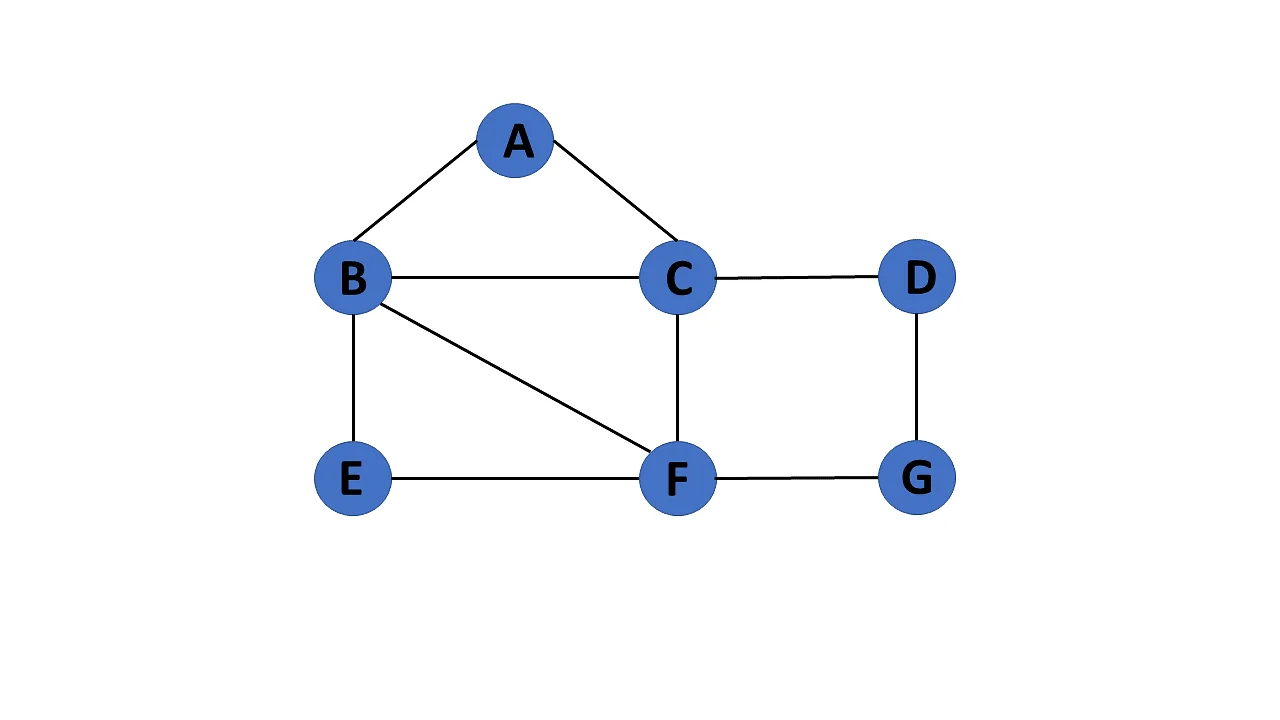
The corresponding dictionary will be the following.

In [2]:
graph = {   "a" : {"b", "c"},
             "b" : {"a", "c", "e", "f"},
             "c" : {"a", "b", "d", "f"},
             "d" : {"c", "g"},
             "e" : {"b", "f"},
             "f" : {"b", "c", "e", "g"},
             "g" : {"d", "f"}
         }

A = Graph(graph)
type(A)

quantum_graph.Graph

First we want others to get access to the graph dictionary, so we use `.show_gd()` to achieve this.

In [3]:
A.show_gd()

{'a': {'b', 'c'},
 'b': {'a', 'c', 'e', 'f'},
 'c': {'a', 'b', 'd', 'f'},
 'd': {'c', 'g'},
 'e': {'b', 'f'},
 'f': {'b', 'c', 'e', 'g'},
 'g': {'d', 'f'}}

Now the most useful thing is to find the vertices and lists, for which we have the methods `.find_vertices_list()`, `.find_vertices()`, `.find_edges()`, `.edges("a")` (vertices connected to a vertex), etc. For a more detailed documentation, use `help(Graph)`.

In [4]:
A.find_vertices_list()

['b', 'e', 'd', 'f', 'c', 'g', 'a']

In [5]:
A.find_edges()

[['a', 'b'],
 ['a', 'c'],
 ['b', 'f'],
 ['b', 'c'],
 ['b', 'e'],
 ['c', 'd'],
 ['c', 'f'],
 ['d', 'g'],
 ['e', 'f'],
 ['f', 'g']]

In [6]:
A.edges("a")

{'b', 'c'}

We also may want to add vertex or edges to a graph, and that's all done here with functions illustrated below.

In [7]:
A.add_vertex("h")

In [8]:
A.find_vertices()

{'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'}

In [9]:
A.add_edge("1","2")

In [10]:
A.show_gd()

{'a': {'b', 'c'},
 'b': {'a', 'c', 'e', 'f'},
 'c': {'a', 'b', 'd', 'f'},
 'd': {'c', 'g'},
 'e': {'b', 'f'},
 'f': {'b', 'c', 'e', 'g'},
 'g': {'d', 'f'},
 'h': set(),
 '2': {'1'},
 '1': {'2'}}

We can also visualize the whole thing using the `.visualize()` method.

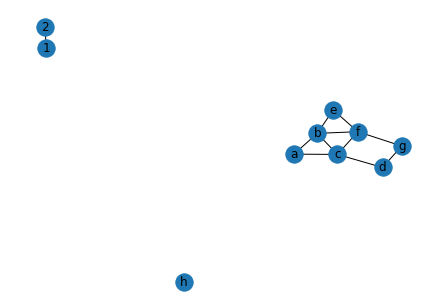

In [11]:
A.visualize()

For more information, see `help(Graph)`.

In [61]:
help(Graph)

Help on class Graph in module quantum_graph:

class Graph(builtins.object)
 |  Graph(graph_dict=None)
 |  
 |  This is the graph object. The input should be a dictionary 
 |  whose keys are the nodes and values are nodes connected to them via an edge.
 |  
 |  This should only be a base object, so only basics should be implemented in this class. 
 |  For more specific and complicated functions, implement in subclasses.
 |  
 |  Inputs
 |  -----------------
 |  graph_dict: The dictionary representation of the graph
 |      type: dictionary
 |      
 |  Public methods
 |  ------------------------
 |  show_gd  :  returns the graph-representing dictionary that is the input.
 |  
 |  find_vertices:  returns a set of vertices.
 |  
 |  find_vertices_list:  returns a list of vertices.
 |  
 |  find_edges： returns a list of edges represented in set of starting point and ending point. 
 |  
 |  find_edges_list： returns a list of edges represented as lists.
 |  
 |  edges_of_vertex： returns a li

# Metric_Graph(Graph)
As we can see from the title, `Metric_Graph` is a subclass of the Graph class. Metric graph is a graph with an interval on each edge, thus we need to input another edge-interval dictionary. So let's use our former examples to generate the dictionary. Let's also assume that in this example all intervals are $[0,1]$.

In [12]:
gd = A.show_gd()
Edges = A.find_edges()
Edges

[['a', 'b'],
 ['a', 'c'],
 ['b', 'f'],
 ['b', 'c'],
 ['b', 'e'],
 ['c', 'd'],
 ['c', 'f'],
 ['d', 'g'],
 ['e', 'f'],
 ['f', 'g'],
 ['2', '1']]

In [13]:
edge_interval_dict = {}
for i in Edges:
    edge_interval_dict["{}".format(i)] = [0,1]
edge_interval_dict

{"['a', 'b']": [0, 1],
 "['a', 'c']": [0, 1],
 "['b', 'f']": [0, 1],
 "['b', 'c']": [0, 1],
 "['b', 'e']": [0, 1],
 "['c', 'd']": [0, 1],
 "['c', 'f']": [0, 1],
 "['d', 'g']": [0, 1],
 "['e', 'f']": [0, 1],
 "['f', 'g']": [0, 1],
 "['2', '1']": [0, 1]}

In [14]:
AM = Metric_Graph(gd, edge_interval_dict)
type(AM)

quantum_graph.Metric_Graph

So we use the `.show_interval` object to display all intervals, and we can also ask the value of an endpoint on an edge using `.show_vertex_value( vertex, edge = None )`.

In [15]:
AM.show_interval()

{"['a', 'b']": [0, 1],
 "['a', 'c']": [0, 1],
 "['b', 'f']": [0, 1],
 "['b', 'c']": [0, 1],
 "['b', 'e']": [0, 1],
 "['c', 'd']": [0, 1],
 "['c', 'f']": [0, 1],
 "['d', 'g']": [0, 1],
 "['e', 'f']": [0, 1],
 "['f', 'g']": [0, 1],
 "['2', '1']": [0, 1]}

In [16]:
AM.show_vertex_value('f',['f', 'g'])

The value of f is 0 in the edge [f,g]


In [17]:
AM.show_vertex_value('f')

The value of f is 0 in the edge [f,g]
The value of f is 1 in the edge [b,f]
The value of f is 1 in the edge [c,f]
The value of f is 1 in the edge [e,f]


# Graph_PDE(Metric_Graph) Object

Here, we add a function to each edge so that the structure of the quantum graph is all up to solve. 

We leave the detailed usage and explanation of this object to later. For now, let's do some math.

For your information, see `help(Graph_PDE)`. Or you can read the explanations in this file for the exact method and tests.

In [63]:
help(Graph_PDE)

Help on class Graph_PDE in module quantum_graph:

class Graph_PDE(Metric_Graph)
 |  Graph_PDE(graph_dict=None, edge_interval_dict=None, PDE_edge_dict=None)
 |  
 |  This is the quantum graph object. It's a subclass of the Metric_Graph object. 
 |  In addition to the graph dictionary and the edge-interval dictionary, there's also an edge-pde input here.
 |  (Even though we always input ODE here, there really is potential to solve PDEs and that's our initial goal, so we put it here.)
 |  
 |  We will implement two methods of solving the system here. 
 |  The first is self-contained solver of the system using discretization.
 |  The other changes the problem into a bvp problem plus an optimization problem.
 |  
 |  Inputs
 |  -----------------
 |  graph_dict: The dictionary representation of the graph
 |      type: dictionary
 |      
 |  edge_interval_dictionary: The dictionary representation of the intervals on each edge
 |      example: {"['a', 'c']": [0, 1]}
 |      type: dictionary
 

# Solving the Quantum graph

Thus, since each edge has an interval and also a function, we first try to solve the Laplace equation
$$\Delta u = f$$ where $\displaystyle\Delta u = \frac{d^2 u}{dx^2}$, and the boundary condition is that for all vertex $v$
$$\sum_{i=1}^k \text{sign}(i)\frac{df_i}{dx}(E_i(v)) = 0 $$
where $E_i(v)$ picks out the value of the vertex at every edge it is on. And the other set of condition is 
$$u_1(v) = u_2(v) = \cdots = u_k(v).$$

But we note that the solution to the euqation is not unique due to addtion of a linear term. Therefore we modify the equation to the form 
$$\Delta u - u = f$$ so that the solution is unique. 

It turns out that solving the method of solving $$\Delta u = f$$ is almost the same as solving $$\Delta u - u = f$$ since we only have to minus an identity matrix to our finite sum matrix. Thus, we explain in detail how to do for the Laplace euqation $\Delta u = f$, then indicate how to modify it to get $\Delta u - u = f$.

## Laplace equation Method 1: Direct finite difference method

Reference is here: https://aquaulb.github.io/book_solving_pde_mooc/solving_pde_mooc/notebooks/03_FiniteDifferences/03_03_BoundaryValueProblems.html

Our goal here is to find a way to solve for $u$ given $f$ and following 3 types of conditions:

Type 1. second order derivative:
$$\Delta u = f$$

Type 2. value of $u$ agrees on nodes. For a vertex $v$, say $u_i$, $i = 1, \cdots, k$ are functions on edges connected to $v$. Then:

$$u_1(v) = u_2(v) = \cdots = u_k(v)$$ 

Type 3. first order derivative: Let sign(i) depends on direction of the edge.
$$\sum_{i=1}^k \text{sign}(i)\frac{du_i}{dx}(v) = 0 $$

Now, say the graph has $m$ edges, $p$ vertices, and each intervals (on edges) are divided into $n$ points. $f_i$, $i = 1, \cdots, m$ denotes the function $f_i$ over $i$-th edge. Let $x_{k,0}, \cdots, x_{k, n-1}$ be the $n$ grid points for the $k$-th edge. Let $T_{k, 0}, \cdots, T_{k, n-1}$ be the solution ($u$'s values) on the grids.


For type 1 conditions, we use the **centered** second-order accurate second-order derivative matrix for the discretization. Hence the values of f at starting point and ending point are not included. For edge $k$, we have:
$$A_k = \frac{1}{\Delta x^2}\left(\begin{array}{cccccccccc}
    1 & -2 & 1 & 0& 0 & \dots & 0 & 0& 0& 0  \\ 
     0&  1 & -2 & 1 &  0 & \dots & 0 & 0& 0& 0  \\ 
   0&  0&  1 & -2 & 1  & \dots & 0 & 0& 0& 0  \\ 
   \vdots &  \ddots &  \ddots & \ddots & \ddots  & \ddots & \ddots & \ddots& \ddots& \vdots  \\ 
    0 & 0& 0& 0 & \ddots & 1 & -2 & 1 & 0&  0 \\
    0 & 0& 0& 0 & \ddots &  0& 1 & -2 & 1 & 0 \\
    0 & 0& 0& 0 & \ddots & 0 &  0& 1 & -2 & 1 \\
\end{array}\right)$$
And
$$A_k \left(\begin{array}{c}
     T_{k, 0} \\
     T_{k, 1} \\
     \vdots \\
     \vdots \\
     \vdots \\
     \vdots \\
     \vdots \\
     T_{k, n-1}
\end{array}\right) = \left(\begin{array}{c}
     f_k(x_{k, 1}) \\
     f_k(x_{k,2}) \\
     \vdots \\
     \vdots \\
     \vdots \\
     \vdots \\
     \vdots \\
     f_k(x_{k, n-2})
\end{array}\right) $$

Let $b_{k, l}$ denotes $f_k(x_{k,l})$
For each $k = 1, \cdots, m$, this gives $(n-2)$ linear equations. We can stack all the equations together blockwise on the diagonal. This gives a big matrix $A$ of size $(n-2)m \times nm$   For example, if $m = 2$. We have the 2 matrices $A_1$ and $A_2$ each representing the ODE on each edge: 
$$A = \left(\begin{array}{cc} A_1 & 0 \\
0 & A_2 
\end{array}\right)$$ 
And thus we have the new equation:
$$
\left(\begin{array}{cc}
A_1 & 0 \\
0 & A_2 
\end{array}\right)\left(\begin{array}{c}
T_{1,0} \\
\vdots\\
T_{1, n-1}\\
T_{2, 0}\\
\vdots\\
T_{2, n-1}
\end{array}\right) = \left(\begin{array}{c}
b_{1, 1} \\
\vdots\\
b_{1, n-2}\\
b_{2, 1}\\
\vdots\\
b_{2, n-2}
\end{array}\right)$$

Boundary contidions:

For type 2 conditions, for a vertex $v$ with degree $d_v$ and values of $u_{v, 1}, \cdots, u_{v, d_v}$ over edges: $T_{v,1}, \cdots, T_{v, d_v}$. We want the corresponding entries (represent $u_d(v)$) in $T_{v, d}$ matches, $d = 1, \cdots, d_v$. This is done by adding a row containing an 1 and -1 at corresponding column indicies. For example, if we want $T_{1,n-1} = T_{2, 0}$, we have this row equation, where we have 1 at the $n$-th column and -1 at the $n+1$-the column:
$$\left(\begin{array}{cccccccc}
0 & \dots & 0 & 1 & -1 & 0 &\dots & 0
\end{array}\right) T = (0)$$
This results in $(2*m - p)$ row equations. 

For type 3 conditions, suppose at vertex "b", we have an interval $T_1$ ending at "b" and an  interval $T_2$ starting at "b". For $u'$ starting at "b", we use the forward difference with coefficients -1.5, 2, 0.5. For $u'$ ending at "b", we use the backward difference with coefficients 1.5, -2, 0.5. We put them on the same row. For example (we may multiply these coefficients by -1 depending on direction of the derivative:
$$\frac{1}{\Delta x}\left(\begin{array}{cccccccc}
0 & \dots & 0 & 1.5 & -2 & 0.5 & -1.5 & 2 &  -0.5& 0 & \dots & 0
\end{array}\right) T = (0)$$

This gives $p$ equations in total for $p$ vertices.

Now, we simply vertically stack all the linear equations (rows, matrices, and values) form a full linear system $M * T = b$, where $M$ is of size $nm \times nm$. Vector $T$ has $nm$ entries, and $b$ has $(n-2)*m $ entries with values from f and $2*m$ zeros. 

With this method you can solve the quantum graph using your favorite way to solve $M * T=b$.

## From Laplace equation to the shifted Laplace equation

Here we discuss how to change only the equation from $\Delta u = f$ into $\Delta u -u = f$. This is actually very simple since we only have to change $A$ into
$$B = A - Id$$
since $AT \approx T''$ and $Id T = T$, where the right hand stays the same. 

All other trivialities in the modification of $b$ and addition of rows of $A$ stays the same through this method, and we will get the solution for the shifted Laplace equation.

This also gives us insight on how to generate the system to any kind of PDEs: simply modifying the solver for 1 edge graph is enough as we will repeatedly use that or stack that up to a larger matrix, which means that our package is actually easy to extend to a fast and general quantum graph solver, given that we have a fast and general solution to a 1D PDE equation.

For the second method, we'll not discuss how the shift is done since it is the same.

## Implementation of optimization method to solve quantum graphs


The graph we use first to test is the first example with every iverval = $[0,1]$ and every right hand side function  = $12x^2-12x+2-(x^2(x-1)^2)$. The reason for this choice is that we want the solution to be $$u = x^2(x-1)^2$$ for the shifted version. So we'd much expect that the shifted version work well while the non-shifted version to be some weird stuff.

The reason we've chosen this test is that we want to first see a case where the expected result is flat at endpoints. We'll see non-flat case later.

In [18]:
graph1 = {   "a" : {"b", "c"},
             "b" : {"a", "c", "e", "f"},
             "c" : {"a", "b", "d", "f"},
             "d" : {"c", "g"},
             "e" : {"b", "f"},
             "f" : {"b", "c", "e", "g"},
             "g" : {"d", "f"}
         }
interval1 = {   "['a', 'c']" : [0, 1],
                "['a', 'b']" : [0, 1],
                "['b', 'f']" : [0, 1],
                "['b', 'c']" : [0, 1],
                "['b', 'e']" : [0, 1],
                "['c', 'f']" : [0, 1],
                "['c', 'd']" : [0, 1],
                "['d', 'g']" : [0, 1],
                "['e', 'f']" : [0, 1],
                "['f', 'g']" : [0, 1]
            }
f = lambda x :  12*x**2-12*x+2-x**2*(x-1)**2
# f = lambda x :  12*x**2-12*x+2
# f = lambda x: -2*np.cos(x)
func1 = {   "['a', 'c']" : f,
                "['a', 'b']" : f,
                "['b', 'f']" : f,
                "['b', 'c']" : f,
                "['b', 'e']" : f,
                "['c', 'f']" : f,
                "['c', 'd']" : f,
                "['d', 'g']" : f,
                "['e', 'f']" : f,
                "['f', 'g']" : f
            }

In [19]:
A4 = Graph_PDE(graph1, interval1, func1)

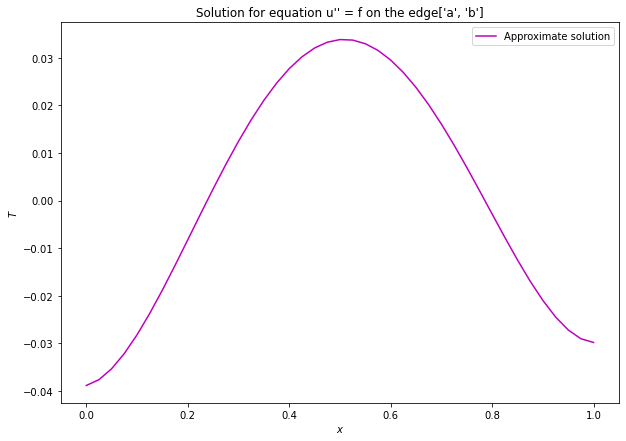

In [20]:
A4.solve_finite_plot(['a','b'])

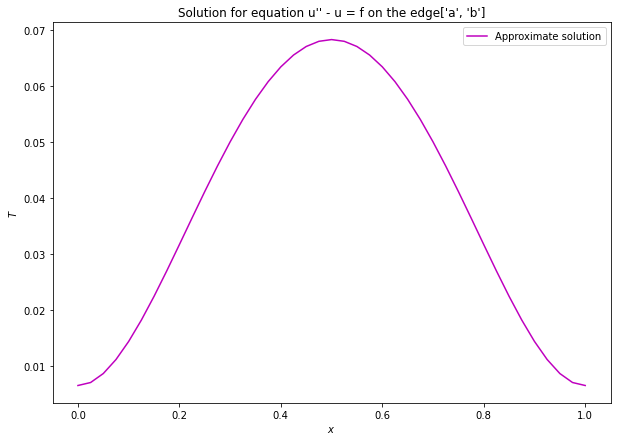

In [21]:
A4.solve_finite_plot_lambda(['a','b'])

So indeed, as we'd expected. 

If you want more example, look above and you'll see that there's some extro choice in the annotated lines for function f.

So now let's see when the connected vertex is not flat: we simply use the expected solution
$$u = \cos(x)$$ on the interval $[0,\pi/2]$ and $[\pi/2,\pi]$ and expect the solution to be well. The computed right hand side is $$f = -2\cos(x)$$ such that $u''-u = f$. So let's see the result below.

In [22]:
graph_1line = {   "a" : {"b"},
                  "b" : {"a", "c"},
                  "c" : {"b"}
              }

interval_1line = {   "['a', 'b']" : [0, np.pi/2],
                     "['b', 'c']" : [np.pi/2, np.pi]
                 }

f = lambda x : -1*np.ones(np.shape(x)[0])
g = lambda x : -(x**4-4*x**3-8*x**2+24*x-8)
hh = lambda x : -2*np.cos(x)
h = lambda x : -np.cos(x*np.pi )*(np.pi**2/4+1)
ode_1line = {   "['a', 'b']" : hh,
                "['b', 'c']" : hh
                #"['a', 'c']" : f
            }

In [23]:
A5 = Graph_PDE(graph_1line, interval_1line, ode_1line)

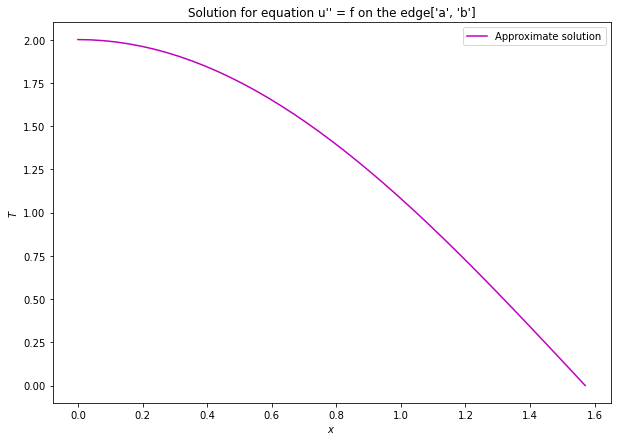

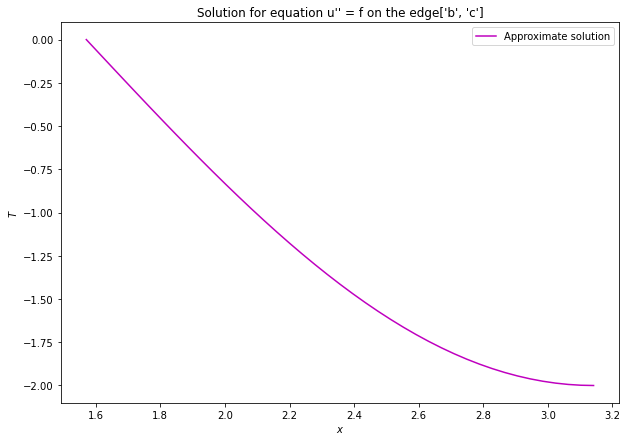

In [24]:
A5.solve_finite_plot(['a','b'])
A5.solve_finite_plot(['b','c'])

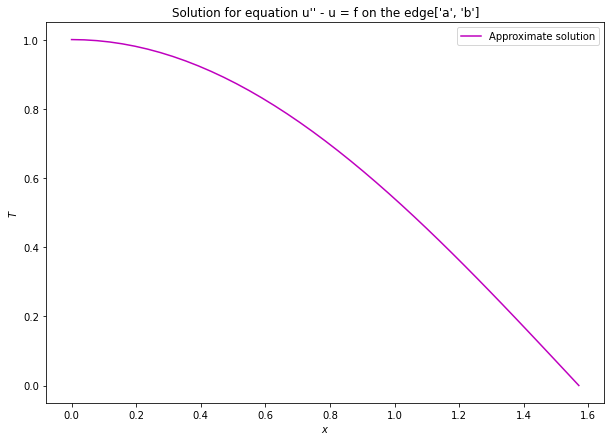

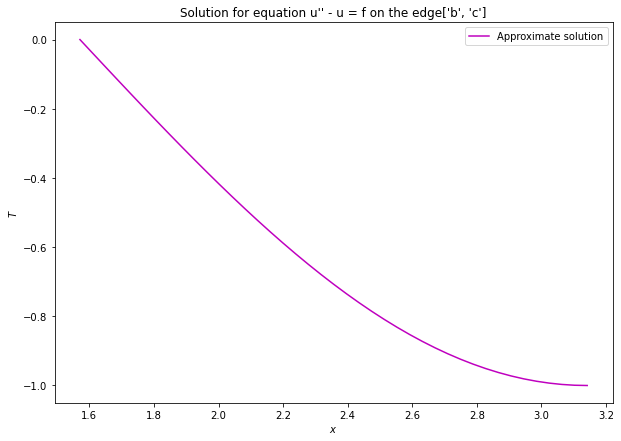

In [25]:
A5.solve_finite_plot_lambda(['a','b'])
A5.solve_finite_plot_lambda(['b','c'])

And everything works quite well.

## Laplace equation Method 2: Optimization

This is another way to solve the question via optimization. To do this, we still need to solve a boundary value problem with the discretization method. Then, we write up a net flow function that computes the flux (sum of derivative at each vertex) and do minimization on this value.

### Step 1: solving the BVP problem.

So to do this, the first step is to introduce the Graph_PDE_BVP object.


So this is an object where with the basic setting of a quantum graph, we require an additional vertex-value dictionary. The reason for this is that we want to solve a BVP problem on the graph. (For more detailed user's manual, look below.)

Note that since we know the value at each vertex, solving an extremely complicated graph is just as easy as solving many individual graphs together. Also note that we are not posing any condition on the derivative at the end points. (So Nuemann condition turns into Dirichlet condition).

How to do this? We use the same finite difference matrix $A$ and get the $AT = b$ equation. 

Note that the derivative at $x_1$ (second grid point) is
$$\frac{T_0-2T_1+T_2}{\Delta x^2} = b_1$$
Thus, to encode the boundary condition $T_0 = aval$ we only need to let $$b_1' = b_1 -\frac{aval}{\Delta x^2},$$ and because of this extra constrain we can discard the first row and manually add the value of $$T_0 = aval.$$ Similarly we have $$b_{n-1} =b_{n-1} -\frac{bval}{\Delta x^2} \;\;\text{ and }\;\; T_{n} = bval.$$

Thus, we can truncate the original matrix to
$$A' = \frac{1}{\Delta x^2}\left(\begin{array}{cccccccccc}
     -2 & 1 & 0& 0 & \dots & 0 & 0& 0 \\ 
      1 & -2 & 1 &  0 & \dots & 0 & 0& 0 \\ 
     0&  1 & -2 & 1  & \dots & 0 & 0& 0 \\ 
    \ddots &  \ddots & \ddots & \ddots  & \ddots & \ddots & \ddots& \ddots \\ 
     0& 0& 0 & \ddots & 1 & -2 & 1 & 0 \\
     0& 0& 0 & \ddots &  0& 1 & -2 & 1  \\
     0& 0& 0 & \ddots & 0 &  0& 1 & -2  \\
\end{array}\right)$$ that is of size $(nx-2)\times(nx-2)$, where nx is the length of the grid of the interval, containing both endpoints. So the equation becomes 
$$ \frac{1}{\Delta x^2}\left(\begin{array}{cccccccccc}
     -2 & 1 & 0& 0 & \dots & 0 & 0& 0 \\ 
      1 & -2 & 1 &  0 & \dots & 0 & 0& 0 \\ 
     0&  1 & -2 & 1  & \dots & 0 & 0& 0 \\ 
    \ddots &  \ddots & \ddots & \ddots  & \ddots & \ddots & \ddots& \ddots \\ 
     0& 0& 0 & \ddots & 1 & -2 & 1 & 0 \\
     0& 0& 0 & \ddots &  0& 1 & -2 & 1  \\
     0& 0& 0 & \ddots & 0 &  0& 1 & -2  \\
\end{array}\right)
\left(\begin{array}{c}
     T_1 \\
     T_2 \\
     \vdots \\
     \vdots \\
     \vdots \\
     T_{n-2}\\
     T_{n-1} 
\end{array}\right) = \left(\begin{array}{c}
     b_1 -\frac{aval}{\Delta x^2}\\
     b_2 \\
     \vdots \\
     \vdots \\
     \vdots \\
     b_{n-2} \\
     b_{n-1}  -\frac{bval}{\Delta x^2}
\end{array}\right)
$$

Thus we have solved the BVP from some required vertex-values.

### Step 2: Solving the minimize problem.

Now that we can solve the equation for any given vertex-value problem on a graph, we can count the netflow of the solution related to it.

To be precise, we use again finite difference to approximate the flow at each vertex. The good thing about finite difference is that we won't have to worry about the direction of the flow anymore since they are already encoded in the expressions
$$F_{in} = -\frac{3}{2} T_{0}+2T_1-\frac{1}{2}T_2\;\;\text{ and }\;\;F_{out} = -\frac{3}{2} T_{n}+2T_{n-1}-\frac{1}{2}T_{n-2}.$$

So what we need to do in this finding netflow function is to find each vertex, sum all fluxes around it using above expressions (make sure in/out matches), taking the absolute value of this flux at one point, and summing up the value for each point.

This done, we can just do minimization on this value for some given starting initial value of each interval ($\in \mathbb{R}^{|V|}$).

## Comparisons

The analysis of both methods tells us that if the graph is simple, like the ones we used as toy examples and tests, then the direct finite sum method should be much faster since it involves only 1 not-so-large matrix multiplication. Whereas the optimization usually compute around 300 steps of guesses and for each step it needs to compute $|E|$ small matrix computations.

However, if the graph is large and complicated, which means $nx\times |E|$ is a huge matrix that we cannot afford to do even with machines, then using the optimization method would be much faster since it is $O(|E| nx^2)$ where as the direct method is $O(|E|^2nx^2)$. (of course you can use clever methods to get faster multiplication, but that works for both method). Yet there also is an iteration on the vertices, so we'll also consider that to get the following.

So in general, the expectation is that for "sparser" graphs, i.e. $|V|$ is large while $|E|$ is small, then it's in principle faster to use the finite difference method.

On the contrary, if the graph is "dense", i.e. $|V|$ is small while $|E|$ is large, then it's expected faster to use the optimization method, even when it's a lot slower for simple examples, as you can see below.

# Graph_PDE_BVP(Graph_PDE) Object:

This object is the bvp setting on a graph. It is essentially easy to solve since give BVP problem we only have to solve the questions 1 by 1. But as we've seen above, it's essential to have this solver to do the optimization object to solve our quantum graph.

For your information, see `help(Graph_PDE_BVP)`.

So let's see how this object is used with some examples.

In [62]:
help(Graph_PDE_BVP)

Help on class Graph_PDE_BVP in module quantum_graph:

class Graph_PDE_BVP(Graph_PDE)
 |  Graph_PDE_BVP(graph_dict=None, edge_interval_dict=None, PDE_edge_dict=None, BVP_dict=None)
 |  
 |  This is the bvp quantum graph object. It's a subclass of the Graph_PDE object. 
 |  In addition to the graph dictionary and the edge-interval dictionary, 
 |      edge-pde-dictionary input, there's also a vertex-value dictionary input.
 |  (Even though we always input ODE here, there really is potential to solve PDEs and that's our initial goal, so we put it here.)
 |  
 |  This is just solving the BVP problem, not directly solving the quantum graph problem. 
 |  However this is everything we need to solve the quantum graph using optimization method.
 |  
 |  Inputs
 |  -----------------
 |  graph_dict: The dictionary representation of the graph
 |      type: dictionary
 |      
 |  edge_interval_dictionary: The dictionary representation of the intervals on each edge
 |      example: {"['a', 'c']": [

In this first example we use the `panda` method which returns a DataFrame that both the other methods use and is easily accessed by everyone, even by users.

So we create a Graph_PDE_BVP with the following inputs:

In [26]:
#Inputs of object
graph1 = {   "a" : {"b", "c"},
             "b" : {"a", "c", "e", "f"},
             "c" : {"a", "b", "d", "f"},
             "d" : {"c", "g"},
             "e" : {"b", "f"},
             "f" : {"b", "c", "e", "g"},
             "g" : {"d", "f"}
         }
interval1 = {   "['a', 'c']" : [0, 1],
                "['a', 'b']" : [1, 2],
                "['b', 'f']" : [2, 4],
                "['b', 'c']" : [2, 1],
                "['b', 'e']" : [0, 1],
                "['c', 'f']" : [0, 1],
                "['c', 'd']" : [0, 1],
                "['d', 'g']" : [0, 1],
                "['e', 'f']" : [0, 1],
                "['f', 'g']" : [0, 1]
            }
f = lambda x :  -np.cos(x*np.pi )*(np.pi**2/4+1)
func1 = {   "['a', 'c']" : f,
                "['a', 'b']" : f,
                "['b', 'f']" : f,
                "['b', 'c']" : f,
                "['b', 'e']" : f,
                "['c', 'f']" : f,
                "['c', 'd']" : f,
                "['d', 'g']" : f,
                "['e', 'f']" : f,
                "['f', 'g']" : f
            }
BVP1 = {   "a" : 3,
             "b" : 4,
             "c" : np.pi,
             "d" : 23,
             "e" : 0.23,
             "f" : -4,
             "g" : 0
         }

In [27]:
BVP_ex1 = Graph_PDE_BVP(graph1,interval1,  func1,BVP1  )

In [28]:
BVP_ex1.panda()

,start,end,starting coord,ending coord,counting,starting value,ending value,f
0,a,c,0,1,1,3.000000,3.141593,<function <lambda> at 0x0000019E5A182AF0>
1,a,b,1,2,2,3.000000,4.000000,<function <lambda> at 0x0000019E5A182AF0>
2,b,f,2,4,3,4.000000,-4.000000,<function <lambda> at 0x0000019E5A182AF0>
3,b,c,2,1,4,4.000000,3.141593,<function <lambda> at 0x0000019E5A182AF0>
4,b,e,0,1,5,4.000000,0.230000,<function <lambda> at 0x0000019E5A182AF0>
5,c,f,0,1,6,3.141593,-4.000000,<function <lambda> at 0x0000019E5A182AF0>
6,c,d,0,1,7,3.141593,23.000000,<function <lambda> at 0x0000019E5A182AF0>
7,d,g,0,1,8,23.000000,0.000000,<function <lambda> at 0x0000019E5A182AF0>
8,e,f,0,1,9,0.230000,-4.000000,<function <lambda> at 0x0000019E5A182AF0>
9,f,g,0,1,10,-4.000000,0.000000,<function <lambda> at 0x0000019E5A182AF0>


So we see that we can access any input data easily by using `.iloc` at the data frame and other basic pandas methods.

We can also try to solve this equation and plot the result, but since it's just cooked up randomly, the result might not be interesting. Still, we use `.solve(edge)` to find the solution of $u'' =  f$ on any edge. The output is a tuple `TS, x, T` where $x$ is the list of grids and $T$ is the solution on each gridpoint. $TS$ is a function that interpolates the solution. To plot, we use `.plot` to get a grid point curve and `.plot_curve` to get a curve.

If we want to solve $u''-u = f$, simply add `_lambda` to each method's name.

So let's try to solve the equation ($f = -1$) on [d,g] just for fun.

In [29]:
BVP_ex1.solve(["d","g"])

(<scipy.interpolate.interpolate.interp1d at 0x19e622cec20>,
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 array([23.        , 22.44149153, 21.88082261, 21.31801325, 20.75309664,
        20.18611897, 19.61713914, 19.04622839, 18.47346986, 17.89895808,
        17.32279841, 16.74510635, 16.16600686, 15.58563356, 15.00412794,
        14.42163847, 13.83831967, 13.2543312 , 12.66983682, 12.08500342,
        11.5       , 10.91499658, 10.33016318,  9.7456688 ,  9.16168033,
         8.57836153,  7.99587206,  7.41436644,  6.83399314,  6.25489365,
         5.67720159,  5.10104192,  4.52653014,  3.95377161,  3.38286086,
         2.81388103,  2.24690336,  1.68198675,  1.11917739,  0.55850847,
         0.        ]))

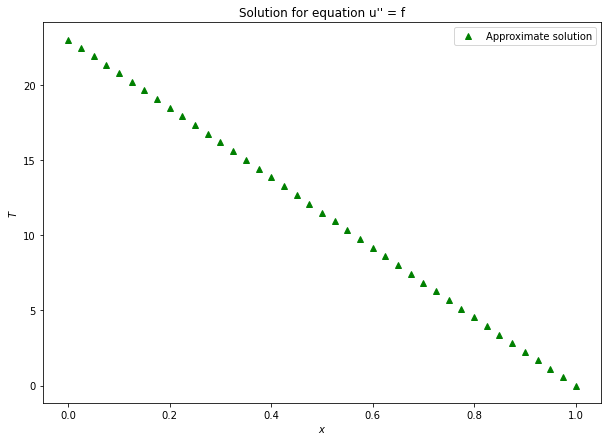

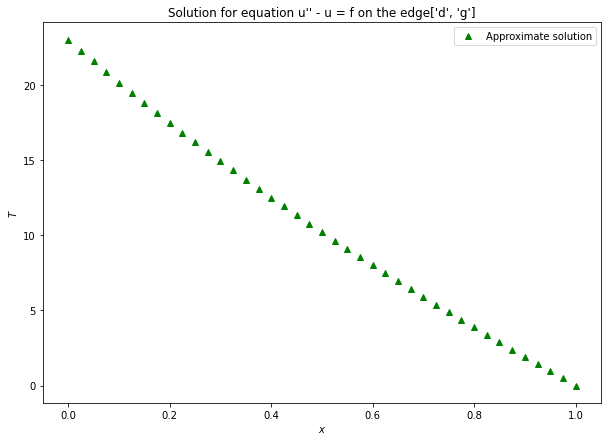

In [30]:
BVP_ex1.plot(["d","g"])
BVP_ex1.plot_lambda(["d","g"])

Now we do the test case for an easy graph with 2 edges that is an equation breaked from between.

The solution we expect is $x^2(x-2)^2$, so that it is flat at $0$ and $2$, and we split the section $[0,2]$ into $[0,1]$ and $[1,2]$:

(If you want to try for a $cos$ example, use function `hh` and change the interval to $[0,\pi/2]$ and $[\pi/2,\pi]$).

In [31]:
graph_1line = {   "a" : {"b"},
                  "b" : {"a", "c"},
                  "c" : {"b"}
              }

interval_1line = {   "['a', 'b']" : [0, 1],
                     "['b', 'c']" : [1, 2]
                 }

f = lambda x : -1*np.ones(np.shape(x)[0])
g = lambda x : -(x**4-4*x**3-8*x**2+24*x-8)
hh = lambda x : -2*np.cos(x)
h = lambda x : -np.cos(x*np.pi )*(np.pi**2/4+1)
ode_1line = {   "['a', 'b']" : g,
                "['b', 'c']" : g
                #"['a', 'c']" : f
            }

bvp_1line = {   "a" : 0,
                "b" : 1,
                "c" : 0
            }

In [32]:
BVP_ex2 = Graph_PDE_BVP(graph_1line,interval_1line,  ode_1line,bvp_1line  )

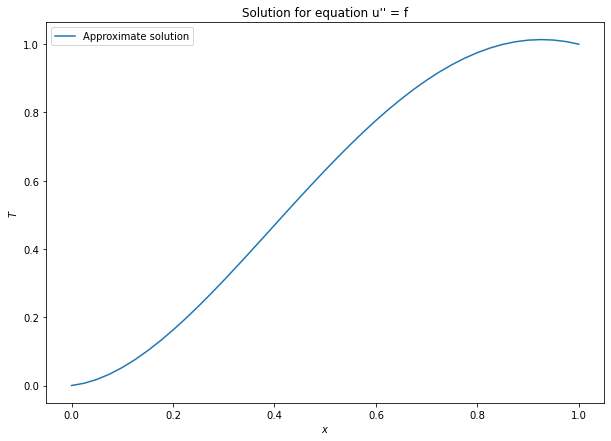

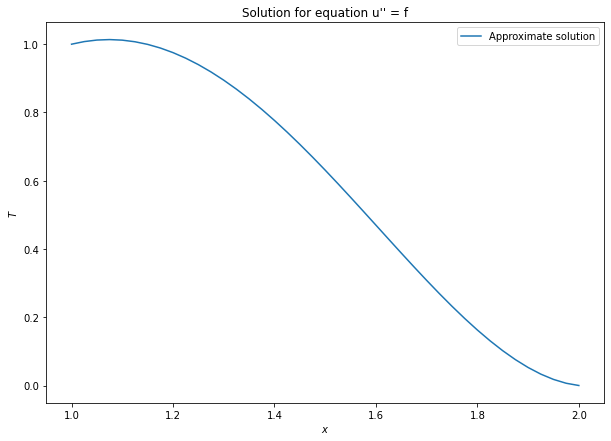

In [33]:
BVP_ex2.plot_curve(["a","b"])
BVP_ex2.plot_curve(["b","c"])

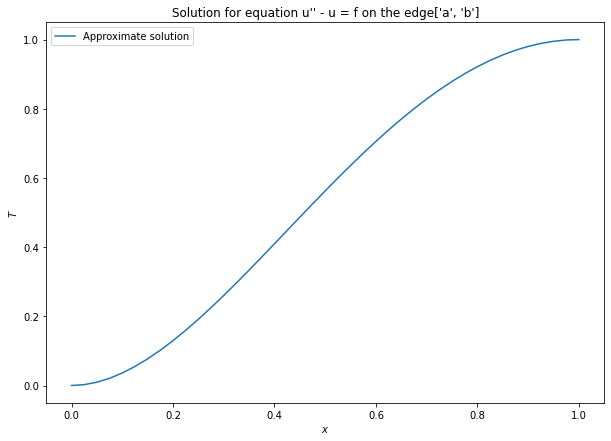

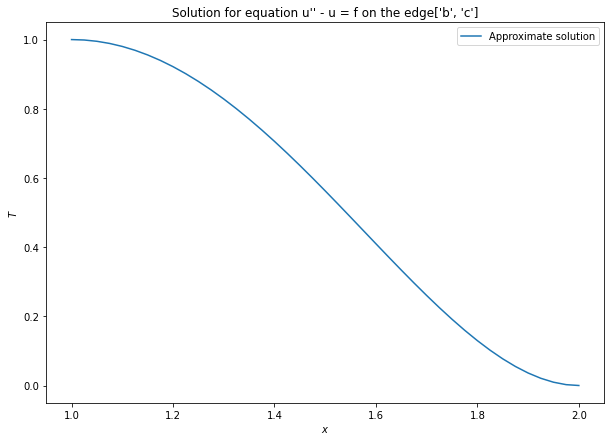

In [34]:
BVP_ex2.plot_curve_lambda(["a","b"])
BVP_ex2.plot_curve_lambda(["b","c"])

Which behaves just like what we want.

# Implementation of optimization method to solve quantum graphs

We've implemented the graph BVP object, so we just need to call that object. Note that what we did here is fine even though we are calling a subclass in the parent class, as we've put it into a package. If it's in the same file, then we'd have to run all objects first before using it.

Let's just use our two examples above and see the results. In the first case no one knows what the result is but we can check whether the netflow after minimization matches our expectation.

In [35]:
#Inputs of object
graph1 = {   "a" : {"b", "c"},
             "b" : {"a", "c", "e", "f"},
             "c" : {"a", "b", "d", "f"},
             "d" : {"c", "g"},
             "e" : {"b", "f"},
             "f" : {"b", "c", "e", "g"},
             "g" : {"d", "f"}
         }
interval1 = {   "['a', 'c']" : [0, 1],
                "['a', 'b']" : [1, 2],
                "['b', 'f']" : [2, 4],
                "['b', 'c']" : [2, 1],
                "['b', 'e']" : [0, 1],
                "['c', 'f']" : [0, 1],
                "['c', 'd']" : [0, 1],
                "['d', 'g']" : [0, 1],
                "['e', 'f']" : [0, 1],
                "['f', 'g']" : [0, 1]
            }
f = lambda x :  -np.cos(x*np.pi )*(np.pi**2/4+1)
func1 = {   "['a', 'c']" : f,
                "['a', 'b']" : f,
                "['b', 'f']" : f,
                "['b', 'c']" : f,
                "['b', 'e']" : f,
                "['c', 'f']" : f,
                "['c', 'd']" : f,
                "['d', 'g']" : f,
                "['e', 'f']" : f,
                "['f', 'g']" : f
            }

In [36]:
qtm_ex1 = Graph_PDE_BVP(graph1,interval1,  func1,BVP1 )

We use the method `.minimize_sol` and `.minimize_sol_lambda` to compute do the minimization. Note that our example here is not at all a well formed quantum graph, so it's really as expected that the solution does not converge to a true solution: there might be none such solution.

In [37]:
inx = np.random.rand(7)

In [38]:
qtm_ex1.minimize_sol(inx)

(      fun: 0.0021344730669942136
  hess_inv: array([[ 0.368409  ,  0.25237633,  0.02772444,  0.13933518, -0.02986414,
          0.07917769,  0.16282608],
        [ 0.25237633,  0.19651641,  0.08683557,  0.14132209,  0.05865675,
          0.11214949,  0.15213688],
        [ 0.02772444,  0.08683557,  0.20198609,  0.14464974,  0.23093385,
          0.17538775,  0.13248843],
        [ 0.13933518,  0.14132209,  0.14464974,  0.14302036,  0.14543228,
          0.14388867,  0.14235153],
        [-0.02986414,  0.05865675,  0.23093385,  0.14543228,  0.27551155,
          0.19134192,  0.12799938],
        [ 0.07917769,  0.11214949,  0.17538775,  0.14388867,  0.19134192,
          0.16119589,  0.13686304],
        [ 0.16282608,  0.15213688,  0.13248843,  0.14235153,  0.12799938,
          0.13686304,  0.14533479]])
       jac: array([-7.07805157e-07,  1.34110451e-06,  8.94069672e-07,  1.86264515e-07,
        -1.63912773e-06,  0.00000000e+00,  0.00000000e+00])
   message: 'Optimization terminated 

In [39]:
qtm_ex1.minimize_sol_lambda(inx)

(      fun: 1.2926154496217812e-06
  hess_inv: array([[ 4.04055133e-07,  2.66322401e-08, -2.40191918e-07,
         -1.25789570e-07, -4.67020006e-07, -1.37363603e-07,
          2.74651790e-08],
        [ 2.66322401e-08,  6.18219768e-09, -1.89574391e-08,
         -3.81931482e-09, -2.66277341e-08, -9.05501047e-09,
          4.02779451e-09],
        [-2.40191918e-07, -1.89574391e-08,  1.71144327e-07,
          6.63648446e-08,  2.93517414e-07,  9.02465103e-08,
         -1.34871045e-08],
        [-1.25789570e-07, -3.81931482e-09,  6.63648446e-08,
          6.22240795e-08,  1.30811585e-07,  4.51392946e-08,
         -1.26439491e-08],
        [-4.67020006e-07, -2.66277341e-08,  2.93517414e-07,
          1.30811585e-07,  6.05759860e-07,  1.39299408e-07,
          1.18890310e-08],
        [-1.37363603e-07, -9.05501047e-09,  9.02465103e-08,
          4.51392946e-08,  1.39299408e-07,  7.46870908e-08,
         -3.42349079e-08],
        [ 2.74651790e-08,  4.02779451e-09, -1.34871045e-08,
         -1.

Now what we do is we create two objects for the two equations' solution that is a Graph_PDE_BVP object using `.minimize_solution_BVP_obj` and `.minimize_solution_BVP_obj_lambda`, for which you know the pattern already. We can easily use methods from Graph_PDE_BVP object to see the solutions inside. It'll take some time since the system is quite big, but it eventually works. (really, 1500 + trials is not a small number.)

### Note that the following is the slowest code all the file, so be patient, it's supposed to be slow 

### This is because the quantum graph is sort of cooked up randomly. Plus there's not a real expected solution to converge to.

In [40]:
q1 = qtm_ex1.minimize_solution_BVP_obj(inx)
q2 = qtm_ex1.minimize_solution_BVP_obj_lambda(inx)

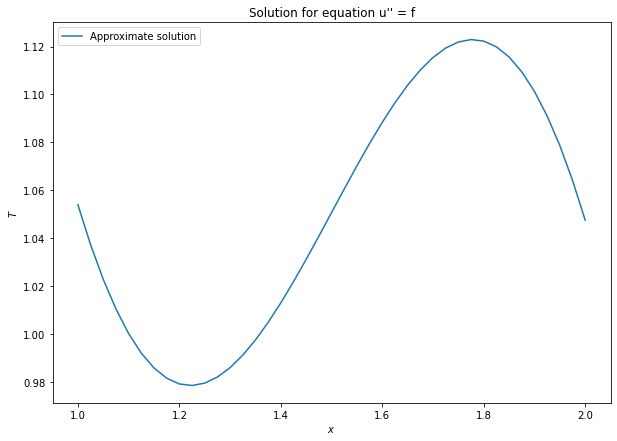

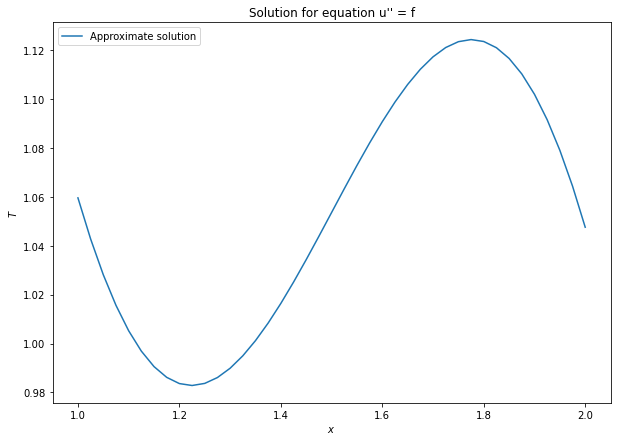

In [41]:
q1.plot_curve(["a","b"])
q1.plot_curve(["b","c"])

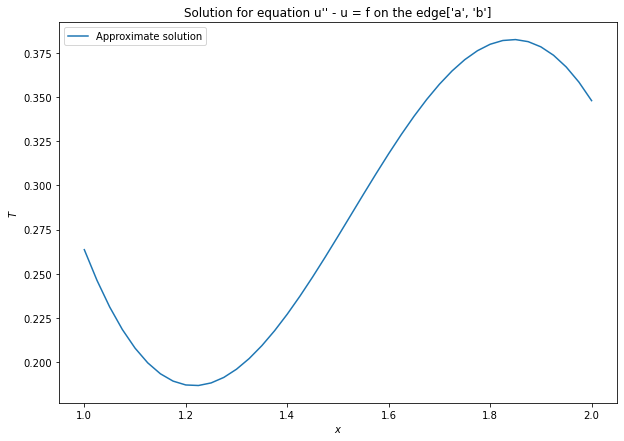

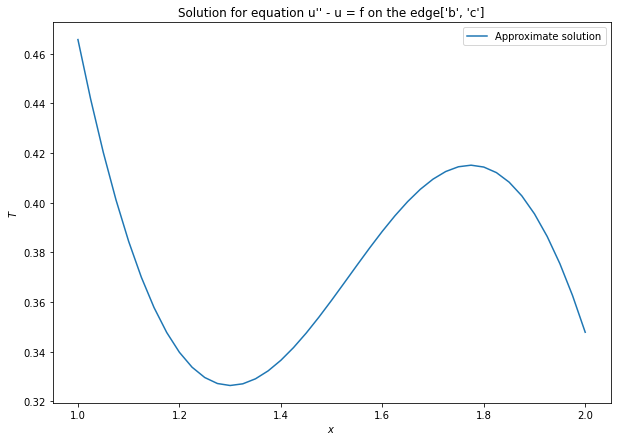

In [42]:
q2.plot_curve_lambda(["a","b"])
q2.plot_curve_lambda(["b","c"])

If you don't like the idea that one has to know about a subclass to get the result, you can also use methods directly in the Graph_PDE object that produces the same result for you. The syntax is `.minimize_solution_plot_curve_lambda(edge , x0 = None)` and you can find all possible methods using help(Graph_PDE).

This is not recommended though, since by the way it is done you have to do the whole minimization process all over again. It's much more recommended to create the Graph_PDE_BVP object. But we'll try for the laplacian equation here and you can see that they are doing the same thing.

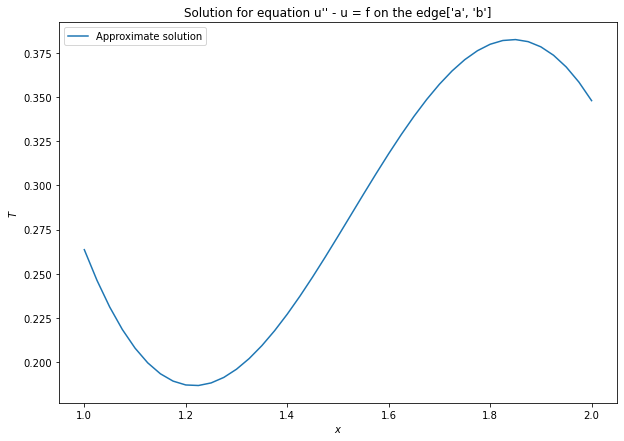

In [43]:
qtm_ex1.minimize_solution_plot_curve_lambda(["a","b"] , inx)

Now let's use something we know the answer to to check the correct ness of this method.

Let's just use the expected solution $u = \cos(x)$ for the $u'' - u = f$ equation. By computation we get that $$f = u'' - u = -2\cos(x)$$and we can compute the solution for $u'' = f$ is $u = 2\cos(x)$. Let's do that on the intervals $[0,\pi/2]$, $[\pi/2,\pi]$, connected at the middle and alone at the end. So we'd expect the solution to be exactly the $\cos$ curve.

In [45]:
graph_1line = {   "a" : {"b"},
                  "b" : {"a", "c"},
                  "c" : {"b"}
              }

interval_1line = {   "['a', 'b']" : [0, np.pi/2],
                     "['b', 'c']" : [np.pi/2, np.pi]
                 }

f = lambda x : -1*np.ones(np.shape(x)[0])
g = lambda x : -(x**4-4*x**3-8*x**2+24*x-8)
hh = lambda x : -2*np.cos(x)
h = lambda x : -np.cos(x*np.pi )*(np.pi**2/4+1)
ode_1line = {   "['a', 'b']" : hh,
                "['b', 'c']" : hh
                #"['a', 'c']" : f
            }

In [46]:
A2 = Graph_PDE(graph_1line, interval_1line, ode_1line)

In [47]:
#inx = [0.8,0,-0.8]
xt = np.random.rand(3)

In [48]:
A2.minimize_sol(xt)

(      fun: 4.0375274548157746e-08
  hess_inv: array([[0.33333257, 0.33333203, 0.3333329 ],
        [0.33333203, 0.33333172, 0.33333229],
        [0.3333329 , 0.33333229, 0.33333331]])
       jac: array([ 2.54647941, -1.27323973, -1.27323827])
   message: 'Desired error not necessarily achieved due to precision loss.'
      nfev: 331
       nit: 18
      njev: 80
    status: 2
   success: False
         x: array([ 0.30324034, -1.69696916,  2.3034498 ]),
 {'b': 0.24751379364000015,
  'c': 0.36060245859744655,
  'a': 0.30160555341757933})

In [49]:
A2.minimize_sol_lambda(xt)

(      fun: 0.005655180888116463
  hess_inv: array([[0.21507249, 0.11198538, 0.07498788],
        [0.11198538, 0.05985299, 0.03755914],
        [0.07498788, 0.03755914, 0.02764614]])
       jac: array([ 1.42291938, -0.6554014 ,  1.52406825])
   message: 'Desired error not necessarily achieved due to precision loss.'
      nfev: 372
       nit: 10
      njev: 90
    status: 2
   success: False
         x: array([-6.99335630e-04, -1.00439973e+00,  1.00089050e+00]),
 {'b': 0.24751379364000015,
  'c': 0.36060245859744655,
  'a': 0.30160555341757933})

In [50]:
AA = A2.minimize_solution_BVP_obj(xt)
AAA = A2.minimize_solution_BVP_obj_lambda(xt)

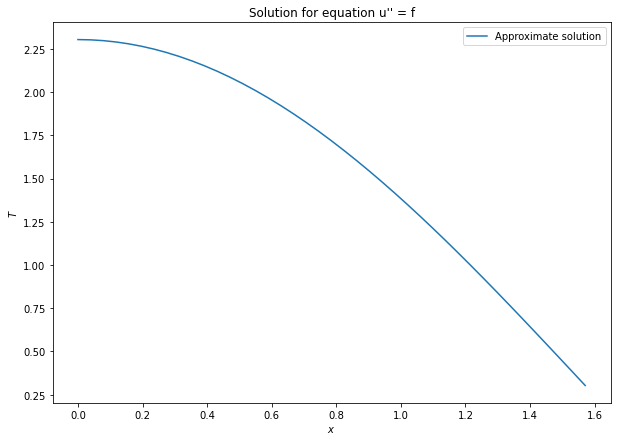

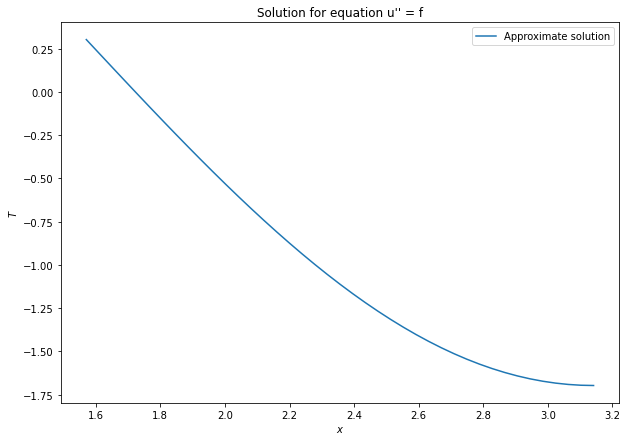

In [51]:
AA.plot_curve(["a","b"])
AA.plot_curve(["b","c"])

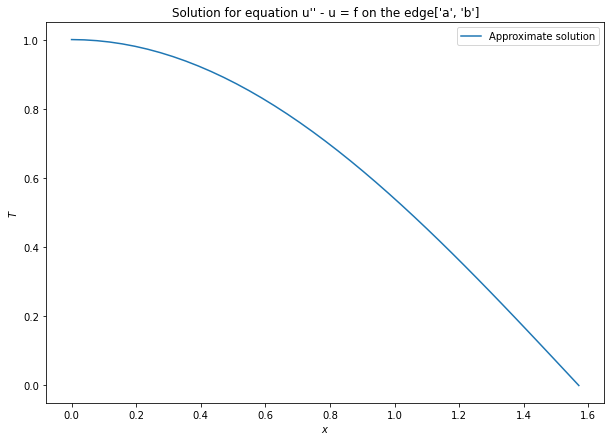

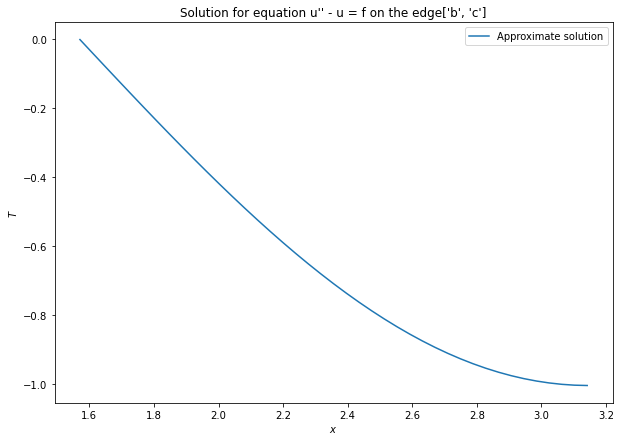

In [52]:
AAA.plot_curve_lambda(["a","b"])
AAA.plot_curve_lambda(["b","c"])

So indeed, for random $x_0$, it produces a pretty good approximation of the expected solution. 

During my testing it turns out that if you start at $x_0 = (0,0,0)$ then the solution will stay at the origin, so this provides us insights of not always start at a vert regular point.

Now we do another example to test it.

We use the same $-2\cos$ function for $f$ but we use a "loop" graph that connects c and a too. And we let the intervals be $[0,2\pi]$ if concatenated. Ideally we'd have a $\cos$ curve again since it's periodic in a good manner. Let's see what happens. 

In [4]:
graph_1line = {   "a" : {"b", "c"},
                  "b" : {"a", "c"},
                  "c" : {"b", "a"}
              }

interval_1line = {   "['a', 'b']" : [0, 2*np.pi/3],
                     "['b', 'c']" : [2*np.pi/3, 4*np.pi/3],
                     "['c', 'a']" : [4*np.pi/3, 2*np.pi]
                 }

f = lambda x : -1*np.ones(np.shape(x)[0])
g = lambda x : -(x**4-4*x**3-8*x**2+24*x-8)
hh = lambda x : -2*np.cos(x)
h = lambda x : -np.cos(x*np.pi )*(np.pi**2/4+1)
ode_1line = {   "['a', 'b']" : hh,
                "['b', 'c']" : hh,
                "['c', 'a']" : hh
                #"['a', 'c']" : f
            }

In [5]:
A3 = Graph_PDE(graph_1line, interval_1line, ode_1line)

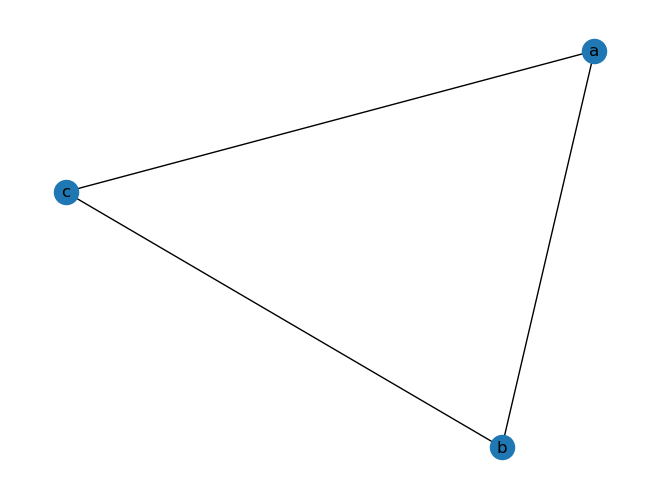

In [6]:
A3.visualize()

In [55]:
#inx = [0.8,0,-0.8]
xt = np.random.rand(3)

In [56]:
A3.minimize_sol(xt)

(      fun: 7.706929935296174e-08
  hess_inv: array([[0.59332088, 0.72619457, 0.46044692],
        [0.72619457, 0.88882544, 0.56356369],
        [0.46044692, 0.56356369, 0.35733008]])
       jac: array([-1.54862733,  0.9549308 ,  1.31616205])
   message: 'Desired error not necessarily achieved due to precision loss.'
      nfev: 323
       nit: 20
      njev: 78
    status: 2
   success: False
         x: array([-0.4454886 , -0.44548857,  2.55504665]),
 {'b': 0.13287189930608478, 'c': 0.7426955438157793, 'a': 0.7885037608692075})

In [57]:
A3.minimize_sol_lambda(xt)

(      fun: 0.007116422915622074
  hess_inv: array([[0.00301399, 0.00592063, 0.00143263],
        [0.00592063, 0.02365893, 0.00458428],
        [0.00143263, 0.00458428, 0.00117913]])
       jac: array([ 2.55934591,  1.57629189, -2.05957307])
   message: 'Desired error not necessarily achieved due to precision loss.'
      nfev: 436
       nit: 9
      njev: 106
    status: 2
   success: False
         x: array([-0.49666246, -0.49959548,  1.00038087]),
 {'b': 0.13287189930608478, 'c': 0.7426955438157793, 'a': 0.7885037608692075})

In [58]:
AA = A3.minimize_solution_BVP_obj(xt)
AAA = A3.minimize_solution_BVP_obj_lambda(xt)

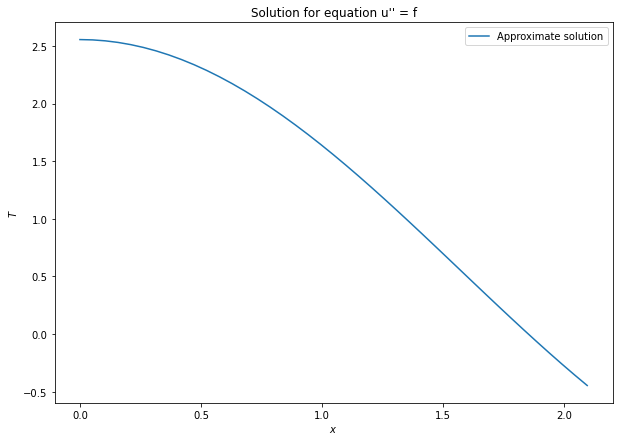

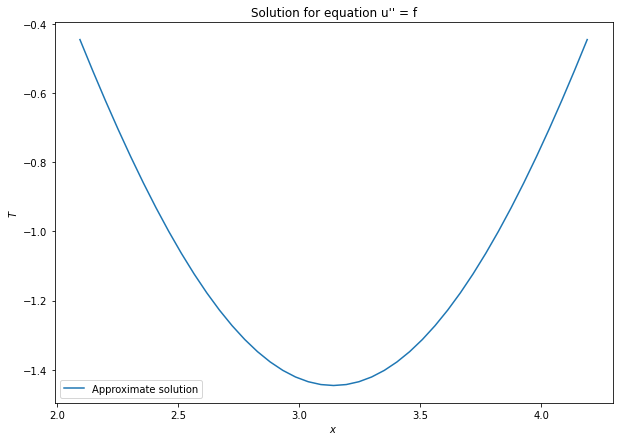

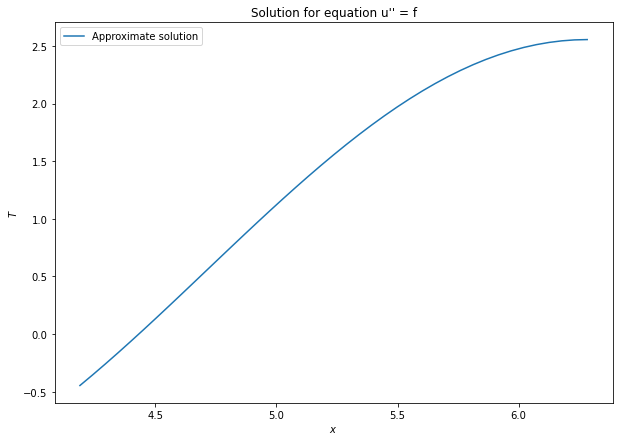

In [59]:
AA.plot_curve(["a","b"])
AA.plot_curve(["b","c"])
AA.plot_curve(["c","a"])

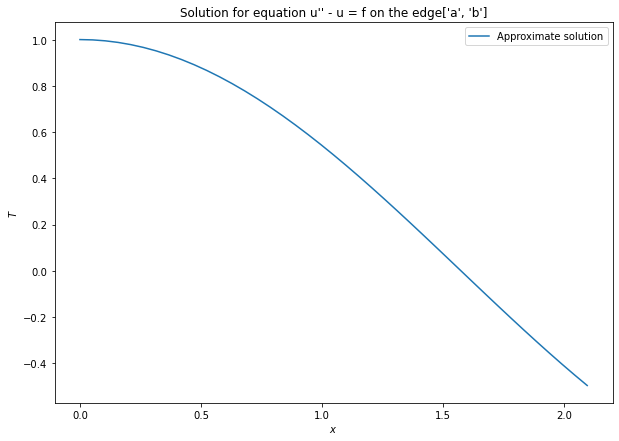

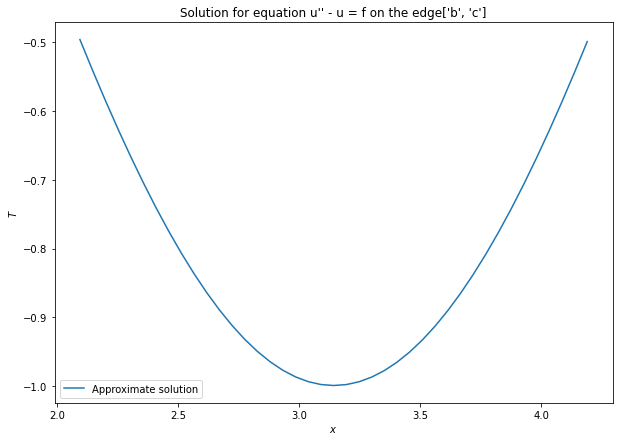

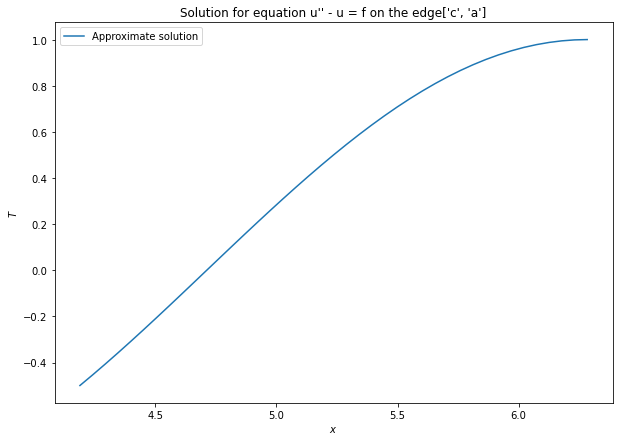

In [60]:
AAA.plot_curve_lambda(["a","b"])
AAA.plot_curve_lambda(["b","c"])
AAA.plot_curve_lambda(["c","a"])

So indeed, the graph is excellent! Only the runtime is a bit slow indeed for the optimization method. But this might excel the finite difference method when the number of edges are super large.